In [70]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import xesmf as xe
import dask
import matplotlib.pyplot as plt 
import matplotlib
from dask_jobqueue import PBSCluster
from dask.distributed import Client

import fates_calibration_library.analysis_functions as analysis
import fates_calibration_library.biome_functions as biomes
import fates_calibration_library.utils as utils
import fates_calibration_library.plotting_functions as plotting

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                                   # The number of cores you want
    memory='25GB',                                             # Amount of memory
    processes=1,                                               # How many processes
    queue='casper',                                            # The type of queue to utilize
    local_directory='/glade/work/afoster',                     # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',                 # Specify resources
    log_directory='/glade/derecho/scratch/afoster/dask_logs',  # log directory
    account='P08010000',                                       # Input your project ID here
    walltime='06:00:00',                                       # Amount of wall time
    interface='ext') 

In [3]:
cluster.scale(30)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.119:41783,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [578]:
# CLM simulation to get TSA, RAIN, and SNOW
clm_sim_dir = os.path.join("/glade/derecho/scratch/afoster/archive",
                            "ctsm60SP_bigleaf_fullgrid/lnd/hist")

# elevation
elev = xr.open_dataset(os.path.join('/glade/work/afoster/FATES_calibration',
                                    'observations/elev.1-deg.nc'),
                       decode_times=False)
elev = elev.isel(time=0)
elev['data'] = xr.where(elev.data > 0.0, elev.data, 0.0)

land_frac_ds = os.path.join(clm_sim_dir, "ctsm60SP_bigleaf_fullgrid.clm2.h0.0001-02-01-00000.nc")
target_grid = analysis.create_target_grid(land_frac_ds, 'FSR')

holdridge_dat = pd.read_csv('/glade/work/afoster/FATES_calibration/observations/holdridge_climates.csv')
holdridge_cols = pd.read_csv('/glade/work/afoster/FATES_calibration/observations/holdridge_colors_reduced.csv')

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 1- 1- 1  1: 0: 1. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001- 1- 1  1: 0: 1). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [171]:
# regrid elevation
regridder = xe.Regridder(elev, target_grid, 'conservative')
elev_regrid = regridder(elev)
elev_regrid['data'] = elev_regrid.landmask*elev_regrid.data

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [294]:
clm_ds = biomes.read_in_clm_sim(clm_sim_dir)

In [298]:
import importlib
import fates_calibration_library.biome_functions
import fates_calibration_library.utils
importlib.reload(fates_calibration_library.biome_functions)
importlib.reload(fates_calibration_library.utils)

<module 'fates_calibration_library.utils' from '/glade/work/afoster/FATES_calibration/fates_calibration_library/fates_calibration_library/utils.py'>

In [591]:
def get_holdridge_zones(clim_dat, holdridge_dat, holdridge_cols):
    
    clim_dat['biome'] = biomes.classify_holdridge(clim_dat, holdridge_dat)
    clim_dat['holdridge_zone'] = xr.apply_ufunc(
        utils.join_nonempty,
        clim_dat["latitude_zone"],
        clim_dat["biome"],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[str]
    )

    fix_dict = {
        'cool temperate dry tundra': 'alpine dry tundra',
        'boreal moist tundra': 'subpolar moist tundra',
        'boreal rain tundra': 'subpolar rain tundra',
        'boreal wet tundra': 'subpolar wet tundra',
        'cool temperate dry scrub': 'boreal dry scrub',
        'cool temperate thorn steppe': 'warm temperate thorn steppe',
        'polar moist tundra': 'polar desert',
        'polar rain forest': 'subpolar rain tundra',
        'polar rain tundra': 'subpolar rain tundra',
        'polar wet tundra': 'subpolar wet tundra',
        'subpolar desert': 'subpolar dry tundra',
        'subpolar moist forest': 'boreal moist forest',
        'subpolar rain forest': 'subpolar rain tundra',
        'subpolar wet forest': 'subpolar wet tundra',
        'subtropical dry scrub': 'subalpine dry scrub',
        'subtropical steppe': 'montane steppe',
        'subtropical very dry forest': 'subtropical dry forest',
        'tropical steppe': 'montane steppe',
        'tropical thorn steppe': 'subtropical thorn steppe',
        'warm temperate dry tundra': 'alpine dry tundra',
        'warm temperate moist tundra': 'alpine moist tundra',
        'warm temperate rain tundra': 'alpine rain tundra',
        'warm temperate steppe': 'cool temperate steppe',
    }
    
    for key, item in fix_dict.items():
      clim_dat['holdridge_zone'] = xr.where(clim_dat.holdridge_zone == key, item, clim_dat.holdridge_zone)

    target_zones = [
        'cool temperate dry forest',
        'cool temperate rain tundra',
        'cool temperate wet tundra',
        'warm temperate dry scrub',
        'warm temperate wet tundra'
    ]
    # Create a boolean mask where the condition is met
    mask_values = np.isin(clim_dat['holdridge_zone'].values, target_zones)
    mask = xr.DataArray(mask_values, coords=clim_dat['holdridge_zone'].coords, dims=clim_dat['holdridge_zone'].dims)
    
    alt_str = clim_dat['altitude_zone'].astype(str).values.astype(str)
    bio_str = clim_dat['biome'].astype(str).values.astype(str)
    
    new_zone_values = np.char.add(np.char.add(alt_str, ' '), bio_str)
    
    # Combine with the existing holdridge_zone conditionally
    clim_dat['holdridge_zone'] = xr.where(mask, new_zone_values, clim_dat['holdridge_zone'])
    
    clim_dat['holdridge_zone'] = xr.where(clim_dat.holdridge_zone == 'alvar wet tundra', 'alpine wet tundra', clim_dat.holdridge_zone)
    clim_dat['holdridge_zone'] = xr.where(clim_dat.holdridge_zone == 'montane dry scrub', 'subalpine dry scrub', clim_dat.holdridge_zone)
    clim_dat['holdridge_zone'] = xr.where(clim_dat.holdridge_zone == 'premontane dry forest', 'subtropical dry forest', clim_dat.holdridge_zone)
    clim_dat['holdridge_zone'] = xr.where(clim_dat.holdridge_zone == 'subalpine rain tundra', 'alpine rain tundra', clim_dat.holdridge_zone)
    clim_dat['holdridge_zone'] = xr.where(clim_dat.holdridge_zone == 'subalpine wet tundra', 'alpine wet tundra', clim_dat.holdridge_zone)
    clim_dat['holdridge_zone'] = xr.where(clim_dat.holdridge_zone == 'subalpine dry tundra', 'alpine dry tundra', clim_dat.holdridge_zone)
    

    labels = holdridge_cols['biome']
    clim_dat['holdridge_int'] = biomes.map_to_int(clim_dat['holdridge_zone'], labels)
    clim_dat = clim_dat.where(target_grid.landmask == 1)

    return clim_dat

In [592]:
clim_dat = biomes.get_holdridge_dat(clm_ds, elev_regrid.data)
clim_dat = get_holdridge_zones(clim_dat, holdridge_dat, holdridge_cols)

In [605]:
len(holdridge_cols.color)

45

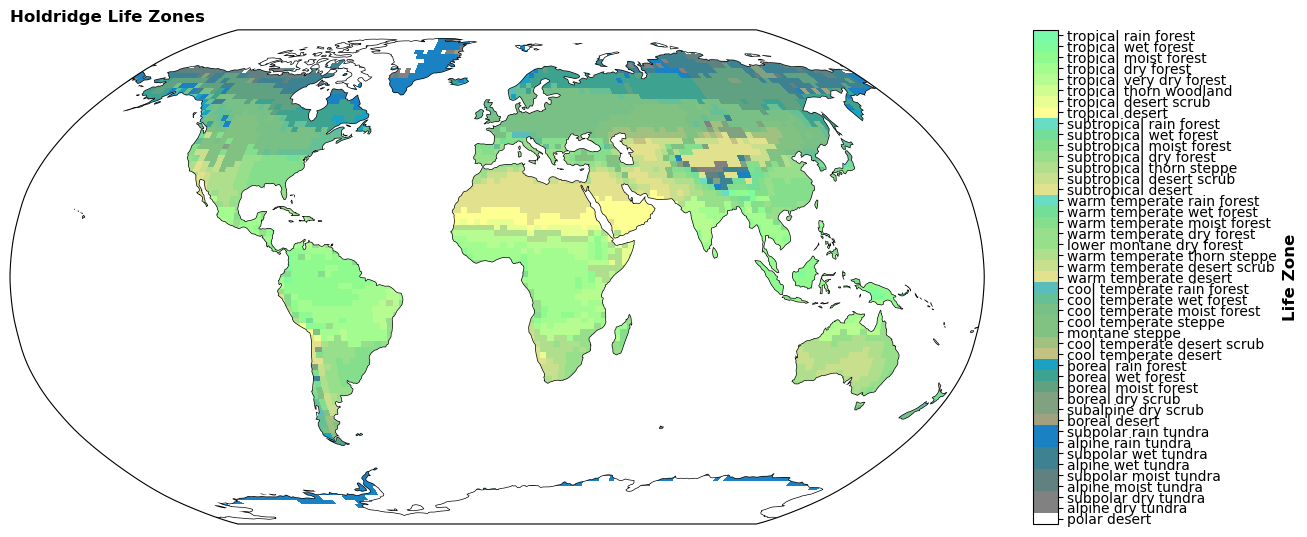

In [609]:
figure, axes = plotting.generate_subplots(1)
cmap = matplotlib.colors.ListedColormap(list(holdridge_cols.color.values))
pcm = plotting.map_function(axes[0], clim_dat.holdridge_int, "Holdridge Life Zones", cmap, -0.5, 44.5)
cbar = figure.colorbar(pcm, ax=axes[0], fraction=0.03, orientation="vertical")
cbar.set_label("Life Zone", size=12, fontweight="bold")
cbar.set_ticks(np.arange(0, 45))
cbar.set_ticklabels(holdridge_cols.biome.values)
plt.savefig('holdridge_life_zones.png')